# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from matplotlib_venn import venn2, venn3

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Curated CSF data set

In [3]:
all_csf = pd.read_csv(data_path + "CSF/all_csf.csv")
print("Number of proteins in CSF data set:", len(all_csf))

Number of proteins in CSF data set: 5781


In [4]:
# # keep subset of studies with 1000+ proteins identified
# csf = all_csf.loc[:, ["Uniprot", "#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
#                    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]]
# csf.dropna(how="all", subset=["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
#                    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"], 
#                     inplace=True)
# csf.to_csv(data_path + "CSF/all_csf_1000plus.csv", index=False)

In [5]:
# with open(data_path + "CSF/all_csf_1000plus_Uniprot.txt", "w") as f:
#     for item in csf["Uniprot"]:
#         f.write("%s\n" % item)

In [6]:
csf = pd.read_csv(data_path + "CSF/all_csf_1000plus.csv")
print("Number of proteins in CSF 1000+ proteins data set:", len(csf))

Number of proteins in CSF 1000+ proteins data set: 5724


In [7]:
csf_seq = pd.read_csv(data_path + "CSF/all_csf_1000plus_Uniprot_seq.tab", sep="\t", header=0, names=["Uniprot", "Sequence"])
# drop entries without sequence (obsolete)
csf_seq.dropna(subset=["Sequence"], inplace=True) # 8 entries dropped
# drop entries with non-standard amino acids
csf_seq = csf_seq[csf_seq["Sequence"].str.contains("B|U|X") == False] # 10 entries dropped

In [8]:
brain_seq = pd.read_csv(data_path + "Brain/Human_brain_Uniprot_seq.csv", sep=";", header=0, names=["Uniprot", "Sequence"])
# drop entries without sequence (obsolete)
brain_seq.dropna(subset=["Sequence"], inplace=True) # 3 entries dropped
# drop entries with non-standard amino acids
brain_seq = brain_seq[brain_seq["Sequence"].str.contains("B|U|X") == False] # 1 entry dropped
len(brain_seq)

2542

## Brain proteome (HPA)

In [9]:
brain_elevated = pd.read_csv(data_path + "Brain/HPA_all_brain_elevated_version21.tsv", sep="\t")
print("Number of brain elevated proteins according to the HPA: %i" % len(brain_elevated))
brain_elevated.dropna(subset=["Uniprot"], inplace=True)
brain_elevated.drop_duplicates(subset=["Uniprot"], inplace=True)
print("Number of brain elevated proteins with a Uniprot ID: %i" % len(brain_elevated))

Number of brain elevated proteins according to the HPA: 2709
Number of brain elevated proteins with a Uniprot ID: 2546


In [10]:
brain_detected = pd.read_csv(data_path + "Brain/HPA_all_brain_detected_version21.tsv", sep="\t", low_memory=False)
print("Number of brain detected proteins according to the HPA: %i" % len(brain_detected))
brain_detected.dropna(subset=["Uniprot"], inplace=True)
brain_detected.drop_duplicates(subset=["Uniprot"], inplace=True)
print("Number of brain detected proteins with a Uniprot ID: %i" % len(brain_detected))

Number of brain detected proteins according to the HPA: 16507
Number of brain detected proteins with a Uniprot ID: 16021


In [11]:
only_brain = pd.read_csv(data_path + "Brain/HPA_only_brain_detected_version21.tsv", sep="\t")
print("Number of only brain detected proteins according to the HPA: %i" % len(only_brain))
only_brain.dropna(subset=["Uniprot"], inplace=True)
only_brain.drop_duplicates(subset=["Uniprot"], inplace=True)
print("Number of only brain detected proteins with a Uniprot ID: %i" % len(only_brain))

Number of only brain detected proteins according to the HPA: 204
Number of only brain detected proteins with a Uniprot ID: 169


In [12]:
def keep_first_uniprot(string):
    if "," in string:
        uniprots = string.split(",")
        uniprot1 = uniprots[0]
    else:
        uniprot1 = string
    
    return uniprot1

def get_brain_expression(string):
    # check if expression for multiple tissues is provided
    if ";" in string:
        tissues = string.split(";")
        for t in tissues:
            # keep only information on brain expression
            if "brain" in t:
                brain_string = t 
    else:
        brain_string = string
    
    # extract expression value from string
    _, exp = brain_string.split(" ")
    exp = float(exp)

    return exp

In [13]:
# if several Uniprots are associated, keep only first
brain_elevated["Uniprot"] = brain_elevated["Uniprot"].apply(keep_first_uniprot)
brain_detected["Uniprot"] = brain_detected["Uniprot"].apply(keep_first_uniprot)
only_brain["Uniprot"] = only_brain["Uniprot"].apply(keep_first_uniprot)

In [14]:
# add column with the mRNA brain expression
brain_elevated["Brain expression"] = brain_elevated["RNA tissue specific nTPM"].apply(get_brain_expression)

In [15]:
brain_elevated[['Gene', 'Uniprot', 'RNA tissue specificity',
       'RNA tissue distribution', 'RNA tissue specificity score',
       'RNA tissue specific nTPM', 'RNA brain regional distribution',
       'RNA brain regional specificity score',
       'RNA brain regional specific nTPM']]

,Gene,Uniprot,RNA tissue specificity,RNA tissue distribution,RNA tissue specificity score,RNA tissue specific nTPM,RNA brain regional distribution,RNA brain regional specificity score,RNA brain regional specific nTPM
0,HCRT,O43612,Tissue enriched,Detected in single,1460.0,brain: 352.2,Detected in many,6.0,amygdala: 104.6;hypothalamus: 352.2
1,CDR1,P51861,Tissue enriched,Detected in many,1159.0,brain: 38856.0,Detected in all,NaN,cerebellum: 38856.0
2,AVP,P01185,Tissue enriched,Detected in some,860.0,brain: 5271.0,Detected in many,12.0,hypothalamus: 5271.0
3,OPALIN,Q96PE5,Group enriched,Detected in some,640.0,brain: 149.9;choroid plexus: 61.5,Detected in all,NaN,NaN
4,BARHL1,Q9BZE3,Tissue enriched,Detected in single,334.0,brain: 34.3,Detected in many,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2704,ZNF804B,A4D1E1,Tissue enhanced,Detected in some,NaN,brain: 2.2;thyroid gland: 4.0,Detected in some,NaN,NaN
2705,ZNF91,Q05481,Tissue enhanced,Detected in many,NaN,brain: 30.4,Detected in many,NaN,cerebellum: 30.4
2706,ZPLD1,Q8TCW7,Tissue enhanced,Detected in some,NaN,brain: 1.3;gallbladder: 2.3;retina: 2.5,Detected in some,NaN,NaN
2707,ZSCAN31,Q96LW9,Tissue enhanced,Detected in all,NaN,brain: 43.6,Detected in all,NaN,NaN


In [16]:
brain_elevated["RNA brain regional distribution"].value_counts(dropna=False)

Detected in all       1471
Detected in many       850
Detected in some       152
Detected in single      73
Name: RNA brain regional distribution, dtype: int64

In [18]:
# cerebellum 117
# hypothalamus 55
# white matter 24
# hippocampal formation 18
# basal ganglia 30
# midbrain 34
# spinal cord 5
# medulla oblongata 21
# amygdala 7
# cerebral cortex 72
# hippocampal formation 18
# medulla oblongata 21

brain_elevated["RNA brain regional specific nTPM"].value_counts(dropna=False)[:50]

brain_regions = ["cerebellum",
"hypothalamus",
"white matter",
"hippocampal formation",
"basal ganglia",
"midbrain",
"spinal cord",
"medulla oblongata",
"amygdala",
"cerebral cortex",
"hippocampal formation",
"medulla oblongata"]

for i in brain_regions:
    print(i, brain_elevated["RNA brain regional specific nTPM"].str.contains(i).sum())

cerebellum 117
hypothalamus 55
white matter 24
hippocampal formation 18
basal ganglia 30
midbrain 34
spinal cord 5
medulla oblongata 21
amygdala 7
cerebral cortex 72
hippocampal formation 18
medulla oblongata 21


# Explorative data analysis

## Count number of studies

In [20]:
all_csf["#Studies"] = all_csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007", 
    "#Peptides_NunezGalindo2015", "#Peptides_Zougman2007", "#Peptides_Schilde2018", "#Peptides_Guo2015", 
    "#Peptides_Stoop2010"]].count(axis=1)

In [21]:
csf["#Studies"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].count(axis=1)

In [22]:
uniprots_csf_studies = {}

# create UniProt lists for each data set
for col in all_csf.columns[1:13]:
    csf_study = all_csf[["Uniprot", col]]
    csf_study.dropna(subset=[col], inplace=True)
    uniprots = set(csf_study["Uniprot"].values)
    uniprots_csf_studies[col] = uniprots

C:\Users\kathi\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


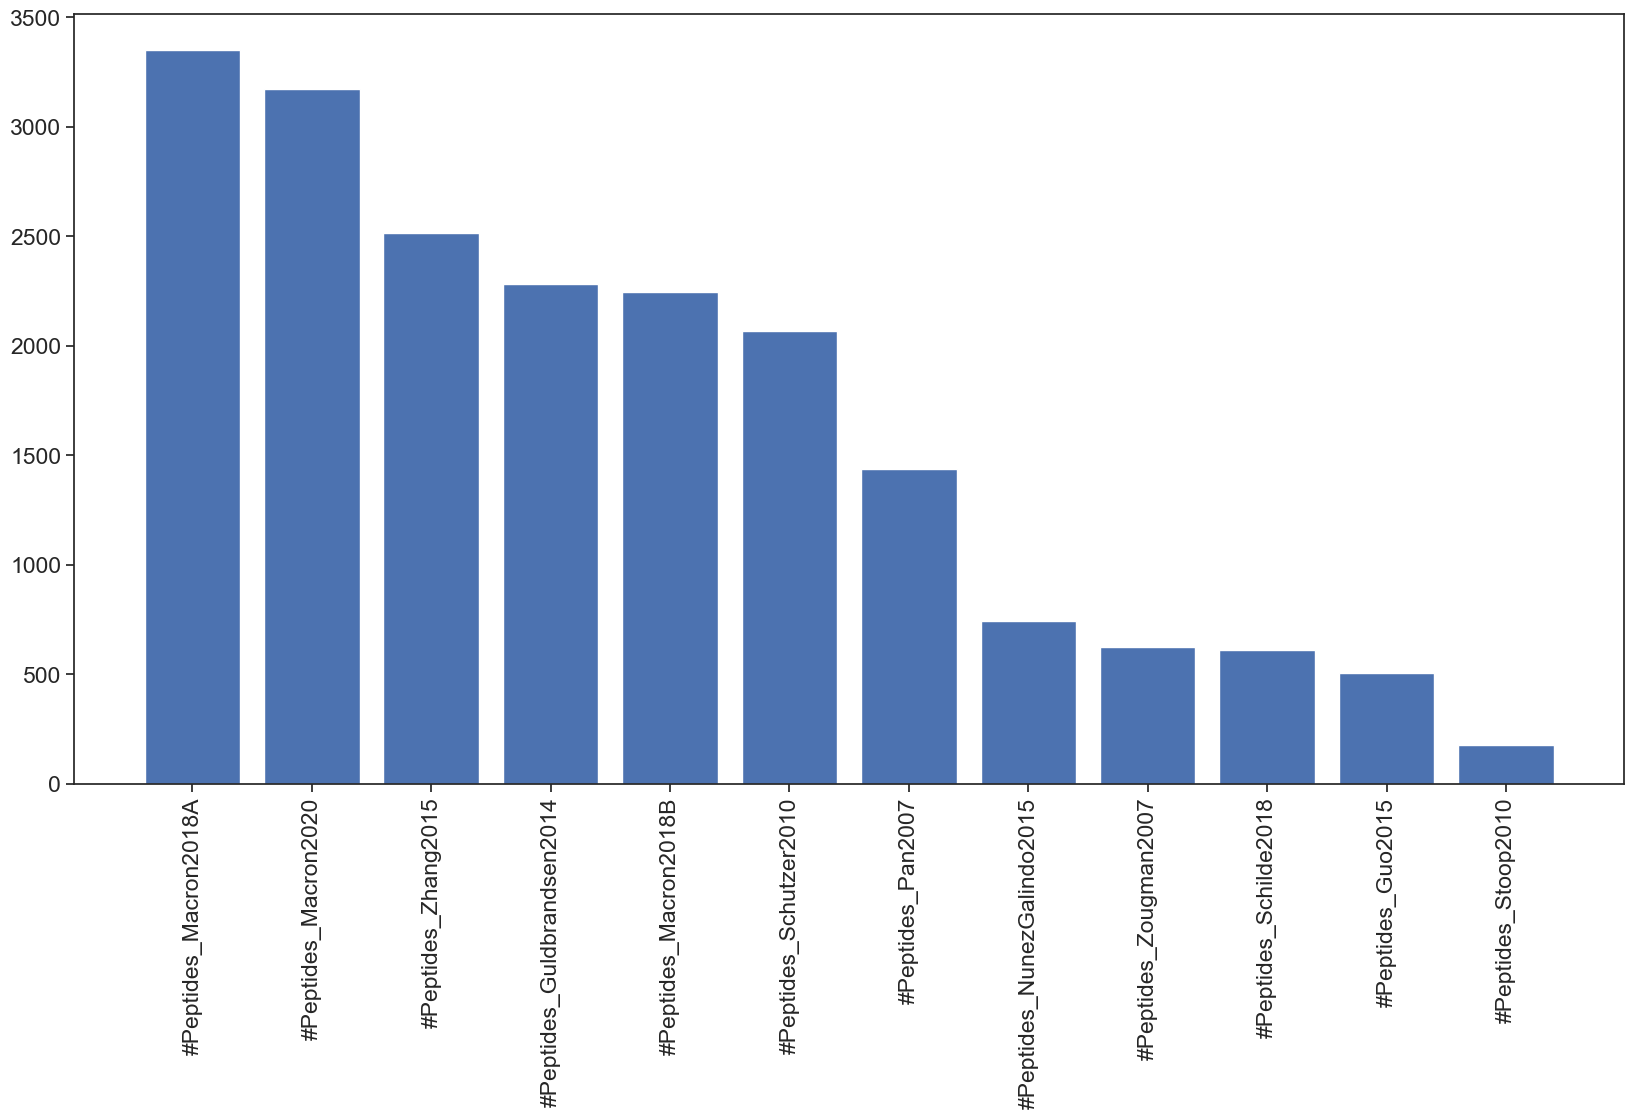

In [23]:
sns.set(style=("ticks"), font_scale=1.5)
fig, axs = plt.subplots(1, 1, figsize=(20,10))

plt.bar(x=uniprots_csf_studies.keys(), height=[len(uniprots_csf_studies[i]) for i in uniprots_csf_studies.keys()])
plt.xticks(rotation=90)
plt.show()

fig.savefig(fig_path + "Peptide_count_per_study.png", bbox_inches="tight")

# Data exploration

## Minimum number of studies per protein

In [24]:
def count_proteins(df):
    """
    Function counts the size of the CSF proteome with specific stringency criteria
    """
    count = []
    labels = []
    for i in range(1, df["#Studies"].max()+1):
        numprot = len(df[df["#Studies"]>=i]) # count how many proteins are identified
        count.append(numprot)
        labels.append("≥" + str(i))
    return labels, count

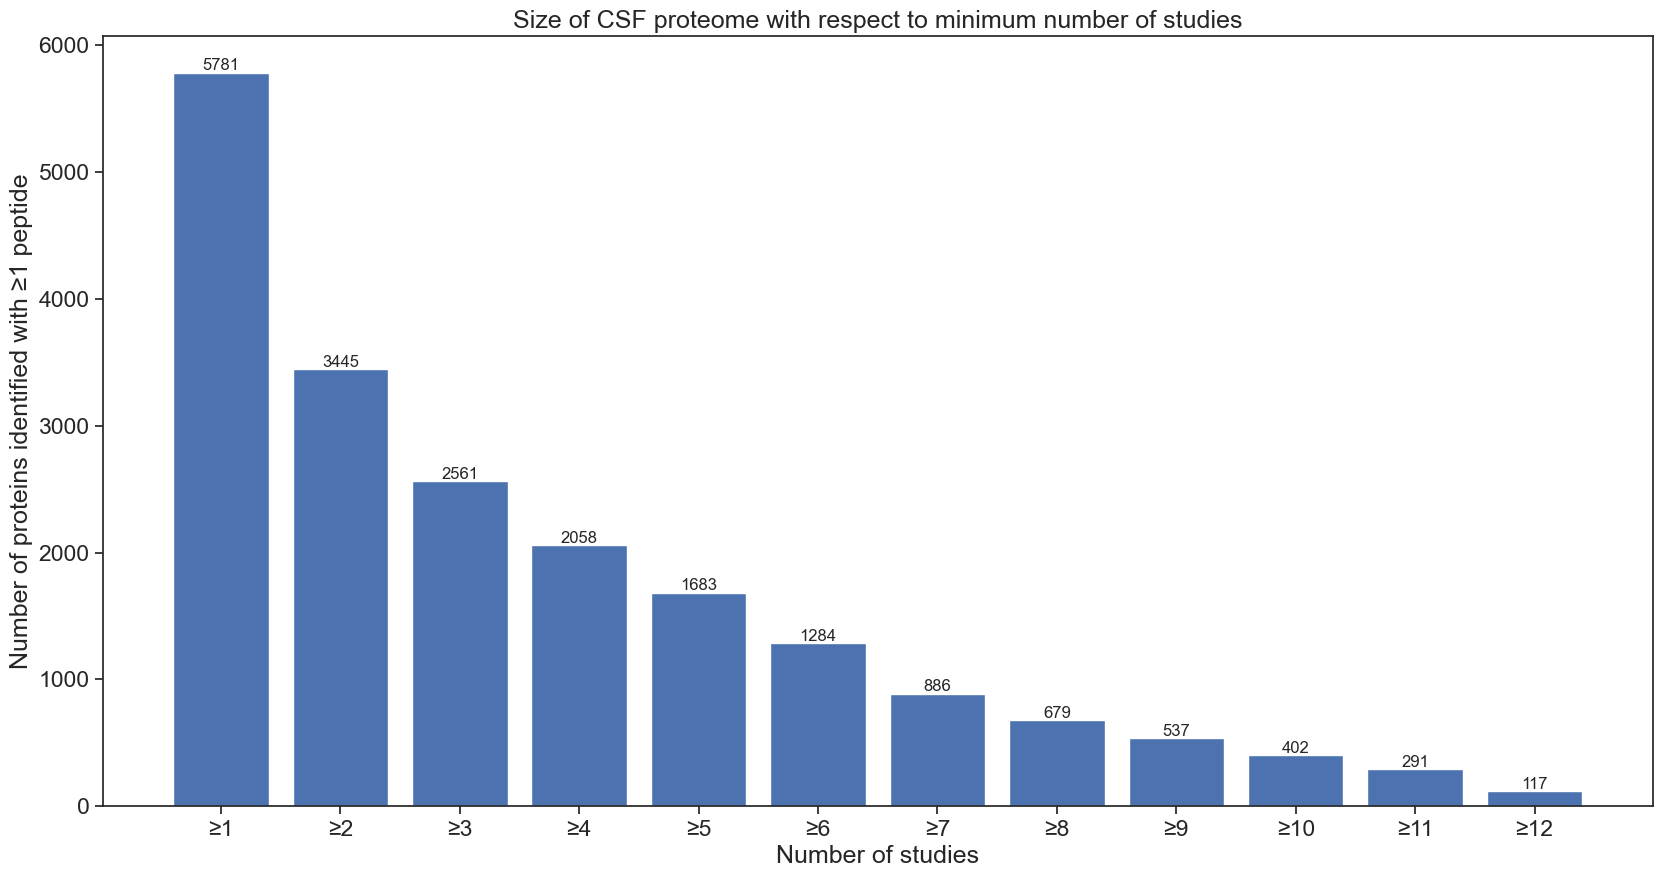

In [25]:
sns.set(style=("ticks"), font_scale=1.5)
fig, axs = plt.subplots(1, 1, figsize=(20,10))

# barplot of size of CSF dataset with varying stringency regarding minimum number of studies
labels, study_count = count_proteins(all_csf)

# plot a barplot of proteinCount
plt.bar(labels, study_count)
# annotate count above bar
for j, p in enumerate(axs.patches):
    count = study_count[j]
    axs.text(p.get_x()+p.get_width()/2., p.get_y()+p.get_height()+20, count, ha="center", size=12) 
plt.xlabel("Number of studies")
plt.ylabel("Number of proteins identified with ≥1 peptide")
plt.title("Size of CSF proteome with respect to minimum number of studies")
plt.show()

fig.savefig(fig_path + "Studies_per_protein_all.png", bbox_inches="tight")

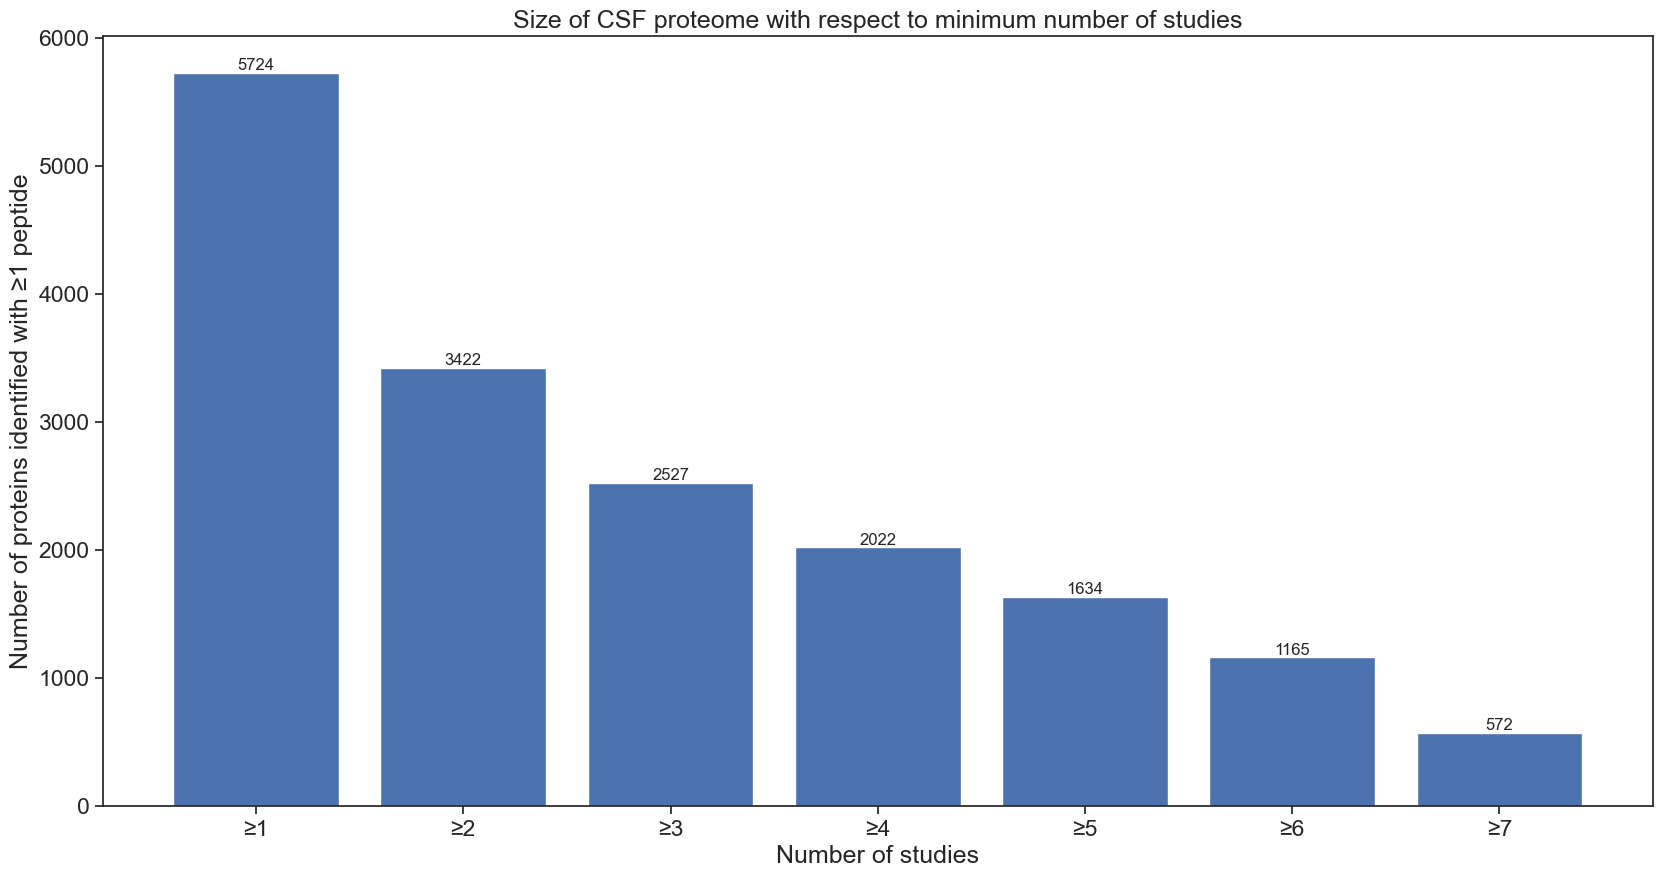

In [29]:
sns.set(style=("ticks"), font_scale=1.5)
fig, axs = plt.subplots(1, 1, figsize=(20,10))

# barplot of size of CSF dataset with varying stringency regarding minimum number of studies
labels, study_count = count_proteins(csf)

# plot a barplot of proteinCount
plt.bar(labels, study_count)
# annotate count above bar
for j, p in enumerate(axs.patches):
    count = study_count[j]
    axs.text(p.get_x()+p.get_width()/2., p.get_y()+p.get_height()+20, count, ha="center", size=12) 
plt.xlabel("Number of studies")
plt.ylabel("Number of proteins identified with ≥1 peptide")
plt.title("Size of CSF proteome with respect to minimum number of studies")
plt.show()

fig.savefig(fig_path + "Studies_per_protein_1000plus.png", bbox_inches="tight")

## Number of peptides per protein

In [30]:
# median, maximum and minimum number of peptides per CSF protein
csf["#Peptides_median"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].median(axis=1)
csf["#Peptides_max"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].max(axis=1)
csf["#Peptides_min"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].min(axis=1)

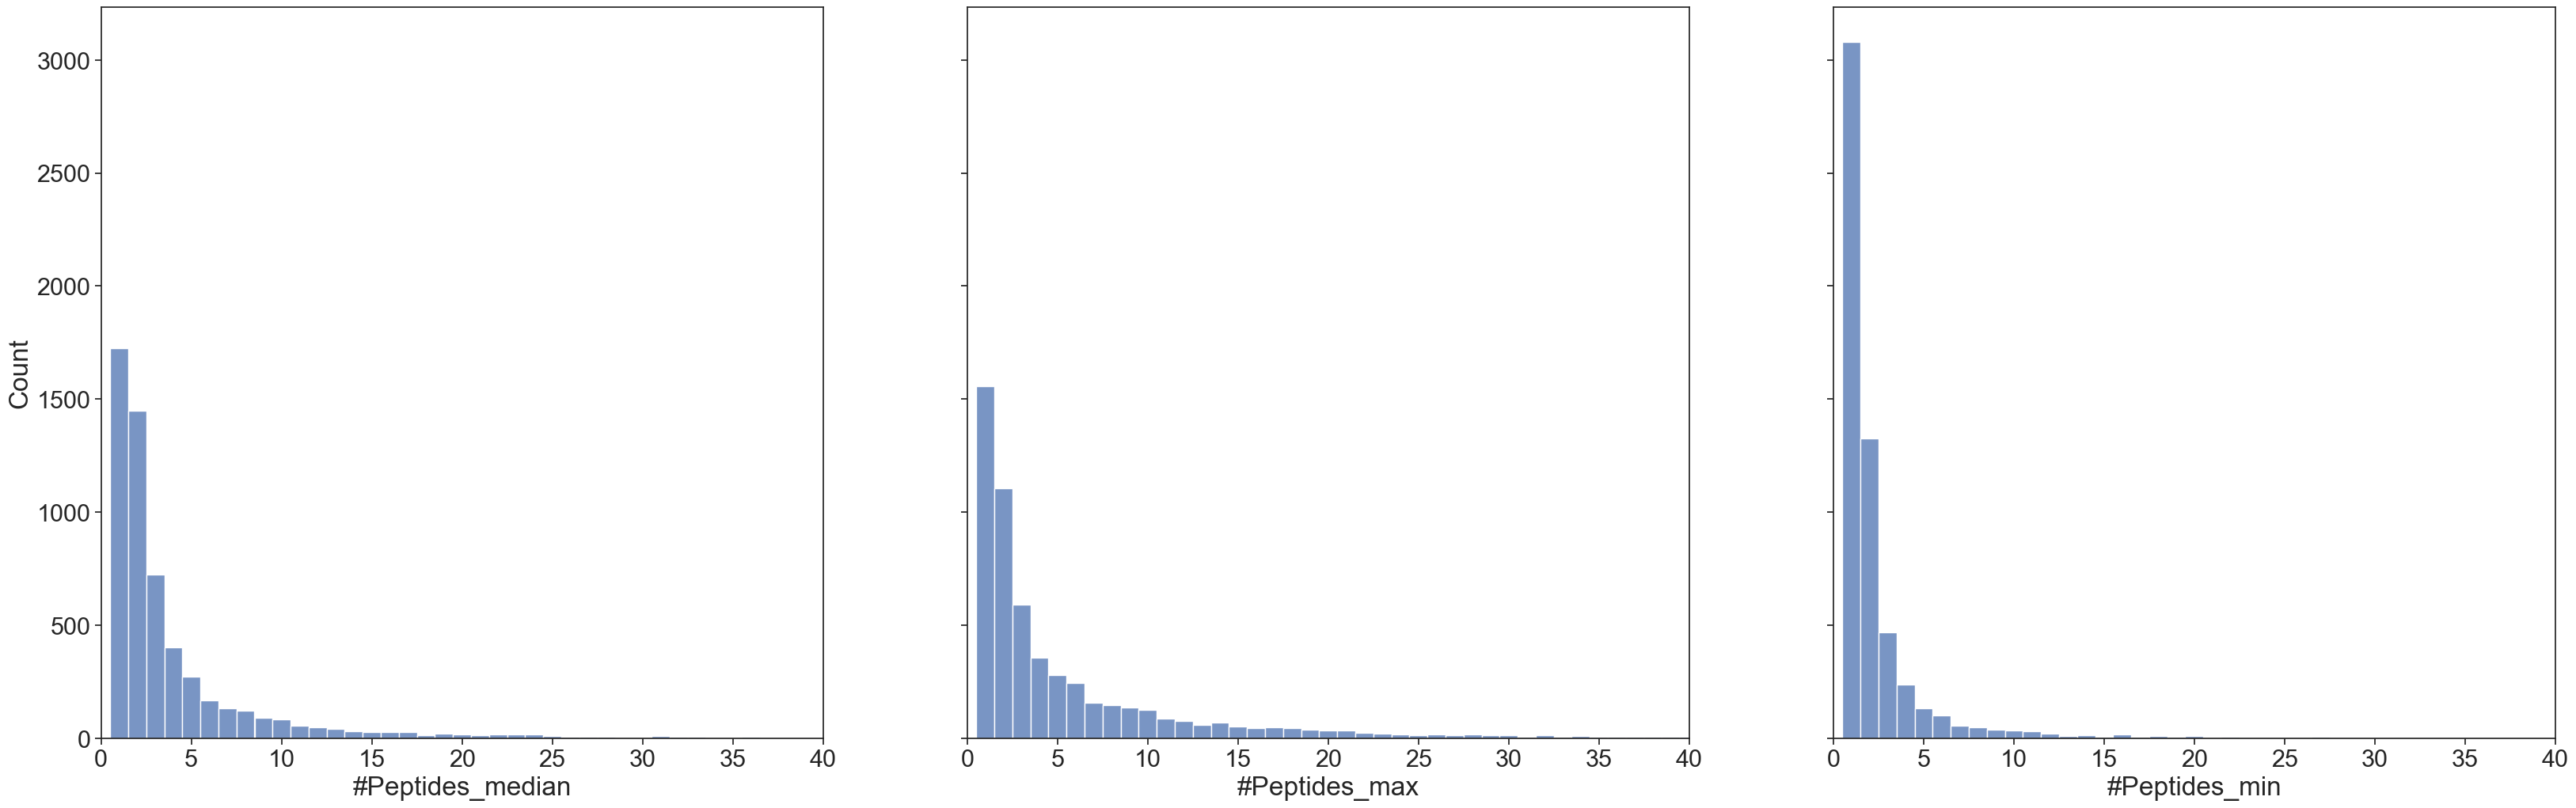

In [31]:
sns.set(style=("ticks"), font_scale=2)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(40,12))
plt.xlim((0,40))

sns.histplot(data=csf, x="#Peptides_median", discrete=True, ax=axs[0])
sns.histplot(data=csf, x="#Peptides_max", discrete=True, ax=axs[1])
sns.histplot(data=csf, x="#Peptides_min", discrete=True, ax=axs[2])
plt.show()

## Study overlap

In [32]:
overlap_array = np.zeros((len(uniprots_csf_studies), len(uniprots_csf_studies)))

for i, study_1 in enumerate(uniprots_csf_studies.keys()):
    
    for j, study_2 in enumerate(uniprots_csf_studies.keys()):
        intersec = uniprots_csf_studies[study_1].intersection(uniprots_csf_studies[study_2])
        overlap = len(intersec)/len(uniprots_csf_studies[study_1])
        overlap_array[i,j] = overlap

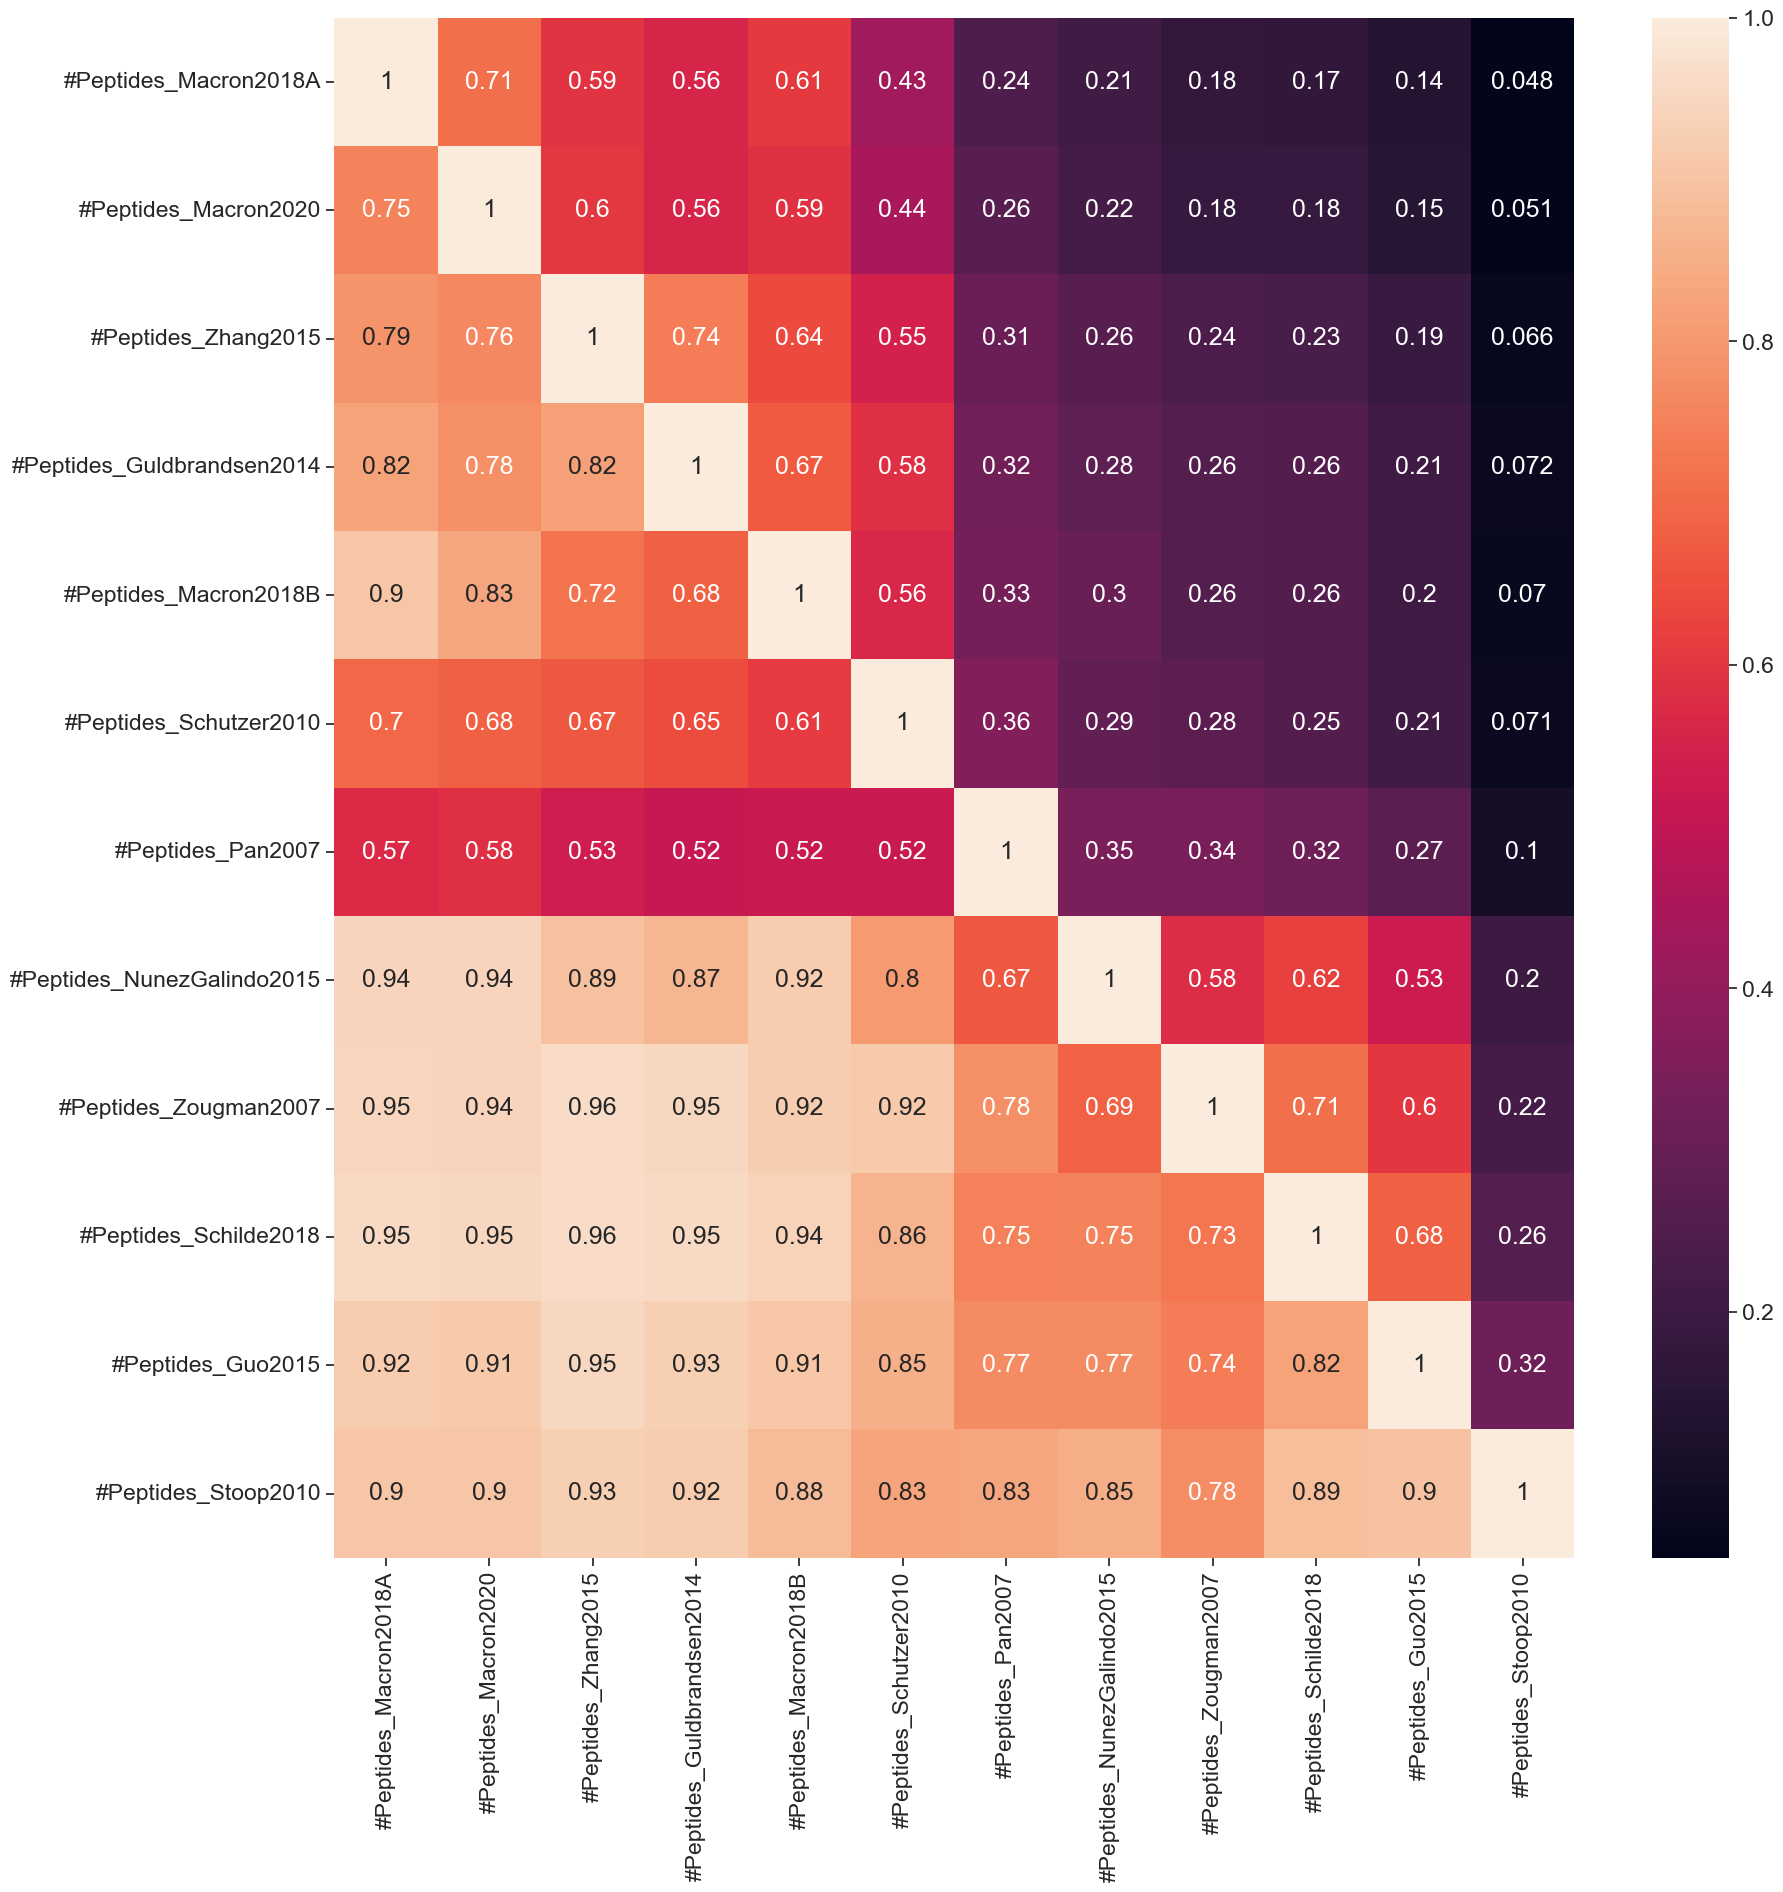

In [33]:
sns.set(style=("ticks"), font_scale=1.5)
fig, axs = plt.subplots(1, 1, figsize=(20,20))

sns.heatmap(overlap_array, annot=True, xticklabels=uniprots_csf_studies.keys(), yticklabels=uniprots_csf_studies.keys())
plt.show()

fig.savefig(fig_path + "Study overlap_heatmap.png", bbox_inches="tight")

## CSF and brain proteome overlap

In [34]:
brain_set = set(brain_elevated["Uniprot"])
brain_detected_set = set(brain_detected["Uniprot"])
only_brain_set = set(only_brain["Uniprot"])
csf_set = set(all_csf["Uniprot"])
csf_1000plus_set = set(csf["Uniprot"])

In [35]:
# save positive and negative protein list
brain_csf_yes = brain_set.intersection(csf_set)
print("Number of brain proteins found in CSF:", len(brain_csf_yes))
brain_csf_no = brain_set.difference(csf_set)
print("Number of brain proteins not found in CSF:", len(brain_csf_no))

Number of brain proteins found in CSF: 999
Number of brain proteins not found in CSF: 1547


In [36]:
# save positive and negative protein list
brain_csf_1000plus_yes = brain_set.intersection(csf_1000plus_set)
print("Number of brain proteins found in CSF:", len(brain_csf_1000plus_yes))
brain_csf_1000plus_no = brain_set.difference(csf_1000plus_set)
print("Number of brain proteins not found in CSF:", len(brain_csf_1000plus_no))

Number of brain proteins found in CSF: 996
Number of brain proteins not found in CSF: 1550


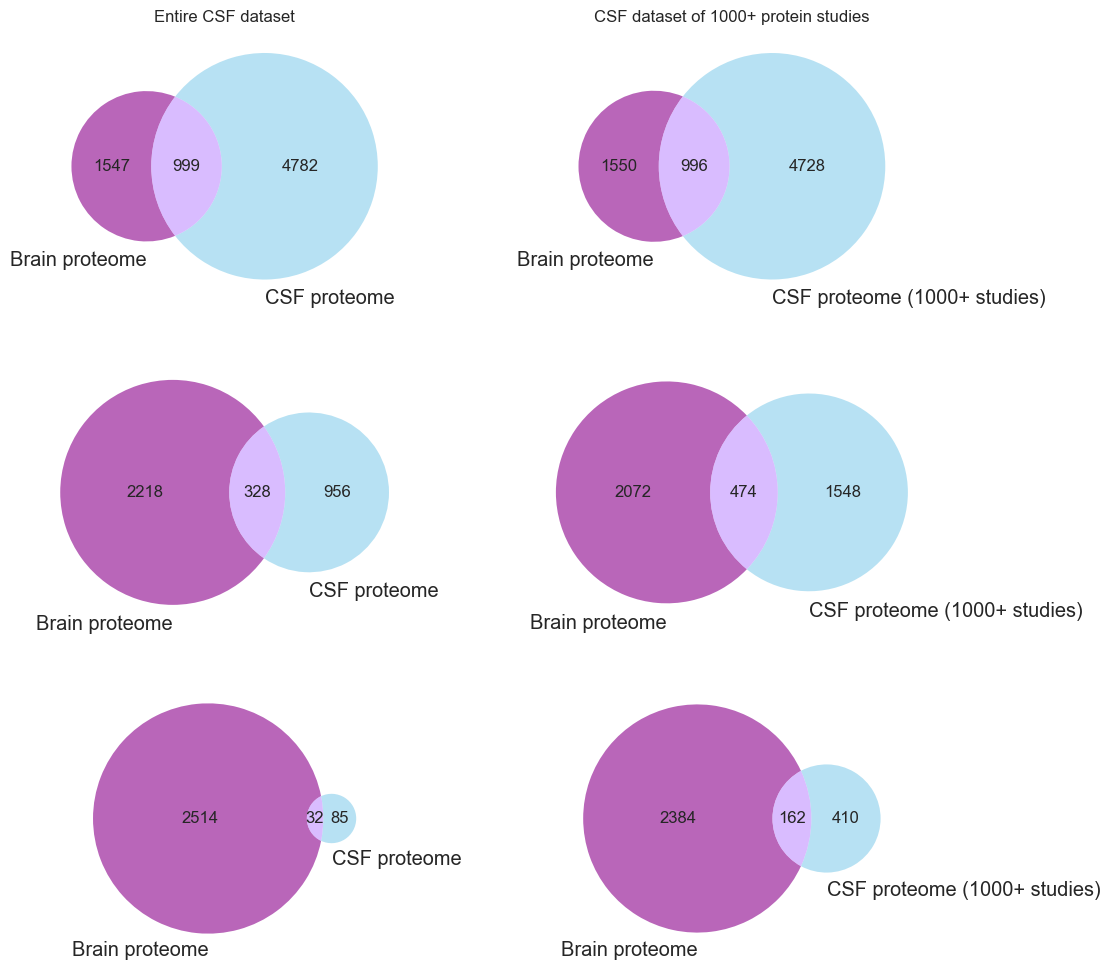

In [37]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
colors=("darkmagenta", "skyblue")
alpha = 0.6

# entire dataset
venn2([brain_set, csf_set], ["Brain proteome", "CSF proteome"], ax=axes[0, 0], set_colors=colors, alpha=alpha)
axes[0, 0].set_title("Entire CSF dataset")
venn2([brain_set, csf_1000plus_set], ["Brain proteome", "CSF proteome (1000+ studies)"], ax=axes[0, 1], set_colors=colors, 
    alpha=alpha)
axes[0, 1].set_title("CSF dataset of 1000+ protein studies")
# at least half of all studies
half_csf_set = set(all_csf[all_csf["#Studies"]>=6]["Uniprot"])
half_csf_1000plus_set = set(csf[csf["#Studies"]>=4]["Uniprot"])
venn2([brain_set, half_csf_set], ["Brain proteome", "CSF proteome"], ax=axes[1, 0], set_colors=colors, alpha=alpha)
venn2([brain_set, half_csf_1000plus_set], ["Brain proteome", "CSF proteome (1000+ studies)"], ax=axes[1, 1], set_colors=colors, 
    alpha=alpha)
# all studies
all_csf_set = set(all_csf[all_csf["#Studies"]>=12]["Uniprot"])
all_csf_1000plus_set = set(csf[csf["#Studies"]>=7]["Uniprot"])
venn2([brain_set, all_csf_set], ["Brain proteome", "CSF proteome"], ax=axes[2, 0], set_colors=colors, alpha=alpha)
venn2([brain_set, all_csf_1000plus_set], ["Brain proteome", "CSF proteome (1000+ studies)"], ax=axes[2, 1], set_colors=colors, 
    alpha=alpha)
plt.show()

fig.savefig(fig_path + "Venn_diagrams_overlap_brain_CSF.png", bbox_inches="tight")

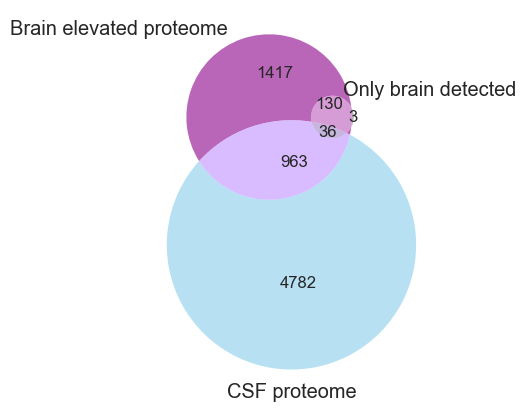

In [38]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors=("darkmagenta", "grey", "skyblue")
alpha = 0.6

# entire dataset
venn3([brain_set, only_brain_set, csf_set], ["Brain elevated proteome", "Only brain detected", "CSF proteome"], 
    set_colors=colors, alpha=alpha)
plt.show()

# fig.savefig(fig_path + "Venn_diagrams_overlap_brain_CSF.png", bbox_inches="tight")

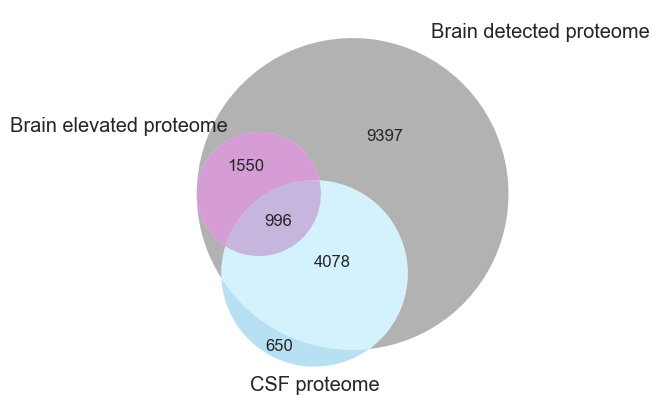

In [39]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors=("darkmagenta", "grey", "skyblue")
alpha = 0.6

# entire dataset
venn3([brain_set, brain_detected_set, csf_1000plus_set], ["Brain elevated proteome", "Brain detected proteome", "CSF proteome"], 
    set_colors=colors, alpha=alpha)
plt.show()

# fig.savefig(fig_path + "Venn_diagrams_overlap_brain_CSF.png", bbox_inches="tight")

In [40]:
# how big is is the overlap with the brain proteome with increasing study number stringency?
overlap_list = []

for i in range(1, all_csf["#Studies"].max()+1):
    core_csf = set(all_csf[all_csf["#Studies"]>=i]["Uniprot"])
    overlap_core_csf_brain = core_csf.intersection(brain_set)
    overlap_per = len(overlap_core_csf_brain)/len(core_csf)
    print("Overlap of CSF and brain proteome for proteins found in a minimum of %d studies is: %.3f."
        % (i, overlap_per))
    overlap_list.append(overlap_per)

Overlap of CSF and brain proteome for proteins found in a minimum of 1 studies is: 0.173.
Overlap of CSF and brain proteome for proteins found in a minimum of 2 studies is: 0.202.
Overlap of CSF and brain proteome for proteins found in a minimum of 3 studies is: 0.213.
Overlap of CSF and brain proteome for proteins found in a minimum of 4 studies is: 0.230.
Overlap of CSF and brain proteome for proteins found in a minimum of 5 studies is: 0.247.
Overlap of CSF and brain proteome for proteins found in a minimum of 6 studies is: 0.255.
Overlap of CSF and brain proteome for proteins found in a minimum of 7 studies is: 0.267.
Overlap of CSF and brain proteome for proteins found in a minimum of 8 studies is: 0.259.
Overlap of CSF and brain proteome for proteins found in a minimum of 9 studies is: 0.251.
Overlap of CSF and brain proteome for proteins found in a minimum of 10 studies is: 0.244.
Overlap of CSF and brain proteome for proteins found in a minimum of 11 studies is: 0.258.
Overlap 

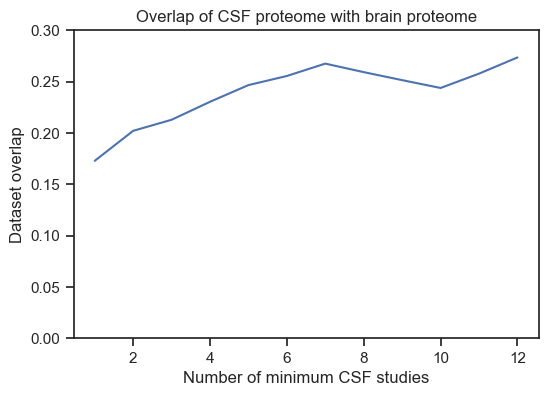

In [41]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(x=range(1, all_csf["#Studies"].max()+1), y=overlap_list)
plt.ylim((0, 0.3))
plt.xlabel("Number of minimum CSF studies")
plt.ylabel("Dataset overlap")
plt.title("Overlap of CSF proteome with brain proteome")
plt.show()

fig.savefig(fig_path + "Overlap_brain_CSF_all.png", bbox_inches="tight")

In [44]:
# how big is is the overlap with the brain proteome with increasing study number stringency?
overlap_list = []

for i in range(1, csf["#Studies"].max()+1):
    core_csf = set(csf[csf["#Studies"]>=i]["Uniprot"])
    overlap_core_csf_brain = core_csf.intersection(brain_set)
    overlap_per = len(overlap_core_csf_brain)/len(core_csf)
    print("Overlap of CSF and brain proteome for proteins found in a minimum of %d studies is: %.3f."
          % (i, overlap_per))
    overlap_list.append(overlap_per)

Overlap of CSF and brain proteome for proteins found in a minimum of 1 studies is: 0.174.
Overlap of CSF and brain proteome for proteins found in a minimum of 2 studies is: 0.203.
Overlap of CSF and brain proteome for proteins found in a minimum of 3 studies is: 0.214.
Overlap of CSF and brain proteome for proteins found in a minimum of 4 studies is: 0.234.
Overlap of CSF and brain proteome for proteins found in a minimum of 5 studies is: 0.249.
Overlap of CSF and brain proteome for proteins found in a minimum of 6 studies is: 0.259.
Overlap of CSF and brain proteome for proteins found in a minimum of 7 studies is: 0.283.


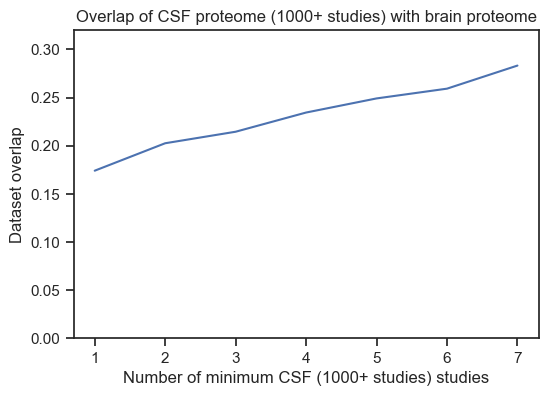

In [48]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(x=range(1, csf["#Studies"].max()+1), y=overlap_list)
plt.ylim((0, 0.32))
plt.xlabel("Number of minimum CSF (1000+ studies) studies")
plt.ylabel("Dataset overlap")
plt.title("Overlap of CSF proteome (1000+ studies) with brain proteome")
plt.show()

fig.savefig(fig_path + "Overlap_brain_CSF_1000plus.png", bbox_inches="tight")

## Constant CSF proteome

In [49]:
csf_constant = all_csf[all_csf["#Studies"] == 12]
csf_constant_set = set(csf_constant["Uniprot"])
print("Number of proteins present in all CSF studies: %d" % len(csf_constant))
brain_csf_constant = brain_set.intersection(csf_constant_set)
print("Number of brain proteins found in CSF in all studies:", len(brain_csf_constant))

Number of proteins present in all CSF studies: 117
Number of brain proteins found in CSF in all studies: 32


In [52]:
csf_constant_1000plus = csf[csf["#Studies"] == 7]
csf_constant_1000plus_set = set(csf["Uniprot"])
print("Number of proteins present in all 1000+ proteins CSF studies: %d" % len(csf_constant_1000plus))
brain_csf_constant_100plus = brain_set.intersection(csf_constant_1000plus_set)
print("Number of brain proteins found in CSF in all 1000+ proteins studies:", len(brain_csf_constant_100plus))

Number of proteins present in all 1000+ proteins CSF studies: 572
Number of brain proteins found in CSF in all 1000+ proteins studies: 996


## Factors of MS detection probability

In [100]:
def calculate_mw(seq):
    
    PA = ProteinAnalysis(seq)
    # molecular weight
    mw = PA.molecular_weight()
    
    return mw

def peptide_category(number):
    if number == 0:
        return "0"
    if number == 1:
        return "1"
    if number == 2:
        return "2"
    if number == 3:
        return "3"
    if number == 4:
        return "4"
    if number == 5:
        return "5"
    if number == 6:
        return "6"
    if number == 7:
        return "7"
    if 7 < number < 10:
        return "8-10"
    if 11 <= number < 21:
        return "11-20"
    if number >= 21:
        return "21+"
    
def peptide_to_binary(number):
    if float(number) == 0:
        return "non-CSF"
    if float(number) > 0:
        return "CSF"

### CSF proteins

#### Molecular weight

In [54]:
csf_peptides = csf[["Uniprot", "#Peptides_median", "#Peptides_max", "#Peptides_min"]]
csf_study_num = csf[["Uniprot", "#Studies"]]
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]

In [55]:
# calculate molecular weight for CSF proteins
csf_seq["Molecular weight"] = csf_seq["Sequence"].apply(calculate_mw)
csf_seq["Molecular weight"] = csf_seq["Molecular weight"] / 1000

In [83]:
# convert peptide number into categories
csf_peptides["Number of peptides"] = csf_peptides["#Peptides_median"].apply(peptide_category)

# add molecular weight as a column
csf_peptides_mass = csf_peptides.merge(csf_seq[["Uniprot", "Molecular weight"]], on="Uniprot", 
    how="inner") # some IDs don't match
csf_peptides_mass["log2(Molecular weight)"] = np.log2(csf_peptides_mass["Molecular weight"])

<ipython-input-83-97dd6eeed062>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csf_peptides["Number of peptides"] = csf_peptides["#Peptides_median"].apply(peptide_category)


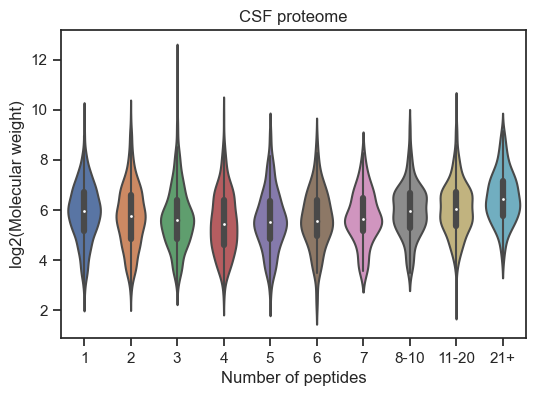

In [58]:
# plot molecular weight vs. number of peptides
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="Number of peptides",  y="log2(Molecular weight)", data=csf_peptides_mass,
            order=["1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"]);
plt.title("CSF proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_peptides.png", bbox_inches="tight")

In [84]:
# plot molecular weight vs. number of studies
csf_study_num_mass = csf_study_num.merge(csf_seq[["Uniprot", "Molecular weight"]], on="Uniprot", how="inner") 
csf_study_num_mass["log2(Molecular weight)"] = np.log2(csf_study_num_mass["Molecular weight"])

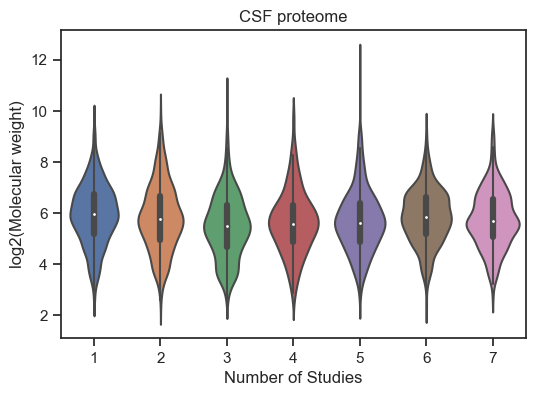

In [60]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="#Studies",  y="log2(Molecular weight)", data=csf_study_num_mass)
plt.xlabel("Number of Studies")
plt.title("CSF proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_studies.png", bbox_inches="tight")

### Brain elevated proteins

#### Molecular weight

In [61]:
# calculate molecular weight for brain proteins
brain_seq["Molecular weight"] = brain_seq["Sequence"].apply(calculate_mw)
brain_seq["Molecular weight"] = brain_seq["Molecular weight"] / 1000
brain_seq

,Uniprot,Sequence,Molecular weight
0,Q8TDC3,MSSGAKEGGGGSPAYHLPHPHPHPPQHAQYVGPYRLEKTLGKGQTG...,85.085749
1,P48065,MDGKVAVQECGPPAVSWVPEEGEKLDQEDEDQVKDRGQWTNKMEFV...,69.367518
2,Q9Y250,MGSVSSLISGHSFHSKHCRASQYKLRKSSHLKKLNRYSDGLLRFGF...,66.612157
3,P0DMW5,MAASAALSAAAAAAALSGLAVRLSRSAAARGSYGAFCKGLTRTLLT...,8.388818
4,P21579,MVSESHHEALAAPPVTTVATVLPSNATEPASPGEGKEDAFSKLKEK...,47.572539
...,...,...,...
2541,Q8IZU8,MALMFTGHLLFLALLMFAFSTFEESVSNYSEWAVFTDDIDQFKTQK...,139.235872
2542,Q4JDL3,MSSPRDFRAEPVNDYEGNDSEAEDLNFRETLPSSSQENTPRSKVFE...,48.422327
2543,Q8N4V2,MEEDLFQLRQLPVVKFRRTGESARSEDDTASGEHEVQIEGVHVGLE...,60.768467
2544,P48426,MATPGNLGSSVLASKTKTKKKHFVAQKVKLFRASDPLLSVLMWGVN...,46.224044


In [85]:
csf_peptides_mass_brain_only = csf_peptides.merge(brain_seq[["Uniprot", "Molecular weight"]], on="Uniprot", how="right") 
csf_peptides_mass_brain_only.fillna(0, inplace=True)
csf_peptides_mass_brain_only["Number of peptides"] = csf_peptides_mass_brain_only["#Peptides_median"].apply(peptide_category)
csf_peptides_mass_brain_only["log2(Molecular weight)"] = np.log2(csf_peptides_mass_brain_only["Molecular weight"])

In [86]:
# csf_peptides_mass_brain_only.groupby("Number of peptides").median()["Molecular weight"].reindex(index = 
#     ["0", "1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"])

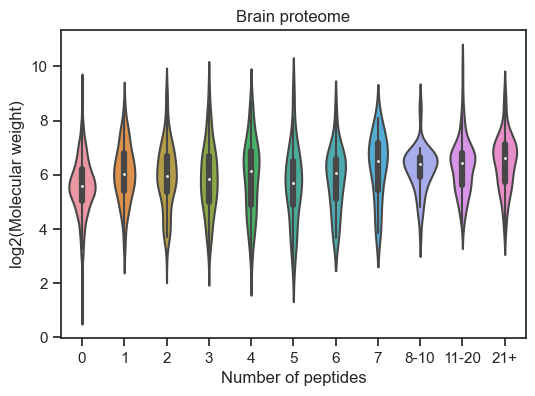

In [64]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="Number of peptides",  y="log2(Molecular weight)", data=csf_peptides_mass_brain_only,
            order=["0", "1", "2", "3", "4", "5", "6", "7", "8-10", "11-20", "21+"]);
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_peptides_brain_only.png", bbox_inches="tight")

In [65]:
csf_study_num_mass_brain_only = csf_study_num.merge(brain_seq[["Uniprot", "Molecular weight"]], on="Uniprot", how="right")
csf_study_num_mass_brain_only["log2(Molecular weight)"] = np.log2(csf_study_num_mass_brain_only["Molecular weight"])
csf_study_num_mass_brain_only.fillna(0, inplace=True)

In [87]:
# csf_study_num_mass_brain_only.groupby("#Studies").describe()["Molecular weight"]

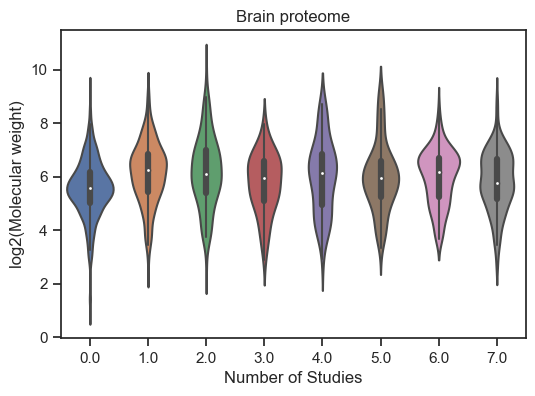

In [67]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="#Studies",  y="log2(Molecular weight)", data=csf_study_num_mass_brain_only)
plt.xlabel("Number of Studies")
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_studies_brain_only.png", bbox_inches="tight")

#### Expression

In [95]:
csf_peptides_exp = csf_peptides.merge(brain_exp, on="Uniprot", how="right")
csf_peptides_exp.fillna(0, inplace=True)
# csf_peptides_exp["Number of peptides"] = csf_peptides_exp["#Peptides_median"].apply(peptide_category)
csf_peptides_exp["log2(Brain expression)"] = np.log2(csf_peptides_exp["Brain expression"])
csf_peptides_exp

,Uniprot,#Peptides_median,#Peptides_max,#Peptides_min,Number of peptides,Brain expression,log2(Brain expression)
0,O43612,1.0,1.0,1.0,1,352.2,8.460251
1,P51861,0.0,0.0,0.0,0,38856.0,15.245850
2,P01185,7.0,10.0,4.0,7,5271.0,12.363861
3,Q96PE5,2.0,2.0,1.0,2,149.9,7.227857
4,Q9BZE3,0.0,0.0,0.0,0,34.3,5.100137
...,...,...,...,...,...,...,...
2541,A4D1E1,0.0,0.0,0.0,0,2.2,1.137504
2542,Q05481,0.0,0.0,0.0,0,30.4,4.925999
2543,Q8TCW7,0.0,0.0,0.0,0,1.3,0.378512
2544,Q96LW9,0.0,0.0,0.0,0,43.6,5.446256


In [88]:
# csf_peptides_exp.groupby("Number of peptides").describe()["Brain expression"].reindex(index = 
#     ["0", "1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"])

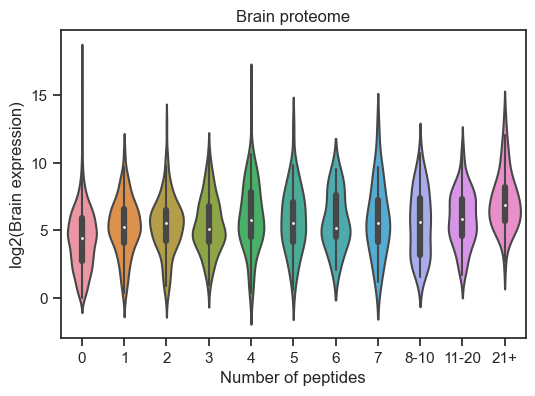

In [72]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="Number of peptides",  y="log2(Brain expression)", data=csf_peptides_exp,
            order=["0", "1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"]);
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Expression_number_of_peptides.png", bbox_inches="tight")

In [89]:
csf_study_num_exp = csf_study_num.merge(brain_exp, on="Uniprot", how="right")
csf_study_num_exp["log2(Brain expression)"] = np.log2(csf_study_num_exp["Brain expression"])
csf_study_num_exp.fillna(0, inplace=True)

In [90]:
# csf_study_num_exp.groupby("#Studies").describe()["Brain expression"]

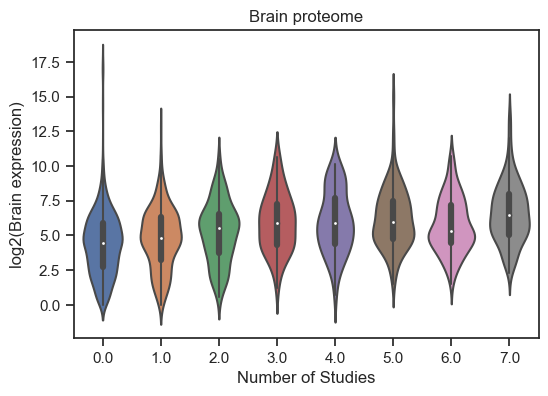

In [75]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="#Studies",  y="log2(Brain expression)", data=csf_study_num_exp)
plt.xlabel("Number of Studies")
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Expression_number_of_studies.png", bbox_inches="tight")

#### Distribution across brain

In [102]:
brain_dist = brain_elevated[["Uniprot", "RNA brain regional distribution"]]
brain_dist

csf_peptides_dist = csf_peptides.merge(brain_dist, on="Uniprot", how="right")
csf_peptides_dist.fillna(0, inplace=True)
csf_peptides_dist["CSF"] = csf_peptides_dist["#Peptides_median"].apply(peptide_to_binary)
csf_peptides_dist

,Uniprot,#Peptides_median,#Peptides_max,#Peptides_min,Number of peptides,RNA brain regional distribution,CSF
0,O43612,1.0,1.0,1.0,1,Detected in many,CSF
1,P51861,0.0,0.0,0.0,0,Detected in all,non-CSF
2,P01185,7.0,10.0,4.0,7,Detected in many,CSF
3,Q96PE5,2.0,2.0,1.0,2,Detected in all,CSF
4,Q9BZE3,0.0,0.0,0.0,0,Detected in many,non-CSF
...,...,...,...,...,...,...,...
2541,A4D1E1,0.0,0.0,0.0,0,Detected in some,non-CSF
2542,Q05481,0.0,0.0,0.0,0,Detected in many,non-CSF
2543,Q8TCW7,0.0,0.0,0.0,0,Detected in some,non-CSF
2544,Q96LW9,0.0,0.0,0.0,0,Detected in all,non-CSF


In [243]:
# order=["Detected in all", "Detected in many", "Detected in some", "Detected in single"],

dist_count = csf_peptides_dist.groupby("CSF")["RNA brain regional distribution"].value_counts(normalize=True)
dist_count = dist_count.to_frame()
dist_count.columns = ["Fraction"]
dist_count = dist_count.unstack()#.loc[order]
dist_count.columns = dist_count.columns.droplevel()
# dist_count.columns = ['Detected in all', 'Detected in many', 'Detected in some', 'Detected in single']
# dist_count = dist_count[['Detected in all', 'Detected in many', 'Detected in some', 'Detected in single']]
# dist_count = dist_count[('Fraction'), ('Detected in all', 'Detected in many', 'Detected in some', 'Detected in single')]
#             ('Fraction',   'Detected in many'),
#             ('Fraction',   'Detected in some'),
#             ('Fraction', 'Detected in single')]

dist_count = dist_count[['Detected in all', 'Detected in many', 'Detected in some', 'Detected in single']]

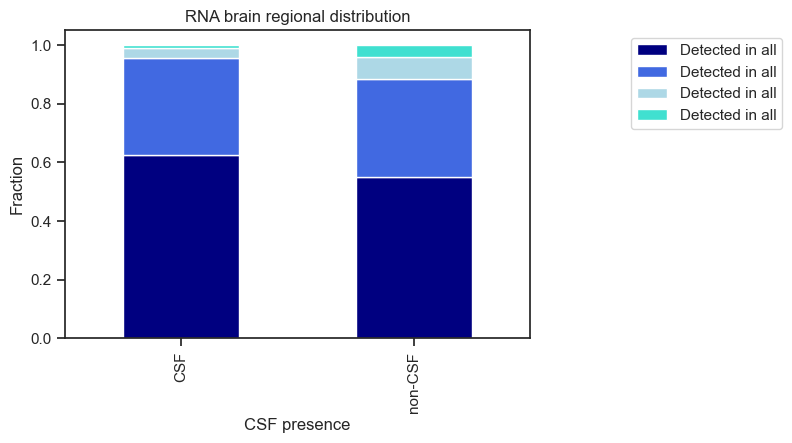

In [244]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

dist_count.plot(kind="bar", stacked=True, color=["navy", "royalblue", "lightblue", "turquoise"], ax=axes)
axes.set(xlabel="CSF presence", ylabel="Fraction", title="RNA brain regional distribution")
axes.legend(labels=["Detected in all", "Detected in many", "Detected in some", "Detected in single"], bbox_to_anchor=(1.2, 1))
plt.show()

## Known amyloidogenic proteins

In [77]:
# # import AmyPro entries (https://amypro.net/#/)
# amypro = pd.read_csv(data_path + "Databases/Amypro.txt", sep="\t")
# print("Known human amyloidogenic proteins in AmyPro database: %i" % len(amypro[amypro["alt_names"] == "Homo sapiens"]))

In [79]:
# print("Amyloidogenic proteins in the brain: %i" % len(set(amypro["species"]).intersection(brain_set)))
# print("Amyloidogenic proteins in the brain that are found in CSF: %i" % len(set(amypro["species"]).intersection(brain_csf_yes)))
# for i in set(amypro["species"]).intersection(brain_csf_yes):
#     print(i)

# Save brain protein lists

### All CSF studies

In [80]:
with open(data_path + "Brain/Brain_all.txt", "w") as f:
    for item in brain_set:
        f.write("%s\n" % item)

with open(data_path + "Brain/Brain_CSF_positive_all.txt", "w") as f:
    for item in brain_csf_yes:
        f.write("%s\n" % item)
        
with open(data_path + "Brain/Brain_CSF_negative_all.txt", "w") as f:
    for item in brain_csf_no:
        f.write("%s\n" % item)

### All CSF (1000+ protein) studies

In [81]:
with open(data_path + "Brain/Brain_all_1000plus.txt", "w") as f:
    for item in brain_set:
        f.write("%s\n" % item)

with open(data_path + "Brain/Brain_CSF_positive_1000plus.txt", "w") as f:
    for item in brain_csf_1000plus_yes:
        f.write("%s\n" % item)
        
with open(data_path + "Brain/Brain_CSF_negative_1000plus.txt", "w") as f:
    for item in brain_csf_1000plus_no:
        f.write("%s\n" % item)

### Constant CSF proteome

In [82]:
with open(data_path + "CSF/constant/CSF_constant.txt", "w") as f:
    for item in csf_constant["Uniprot"]:
        f.write("%s\n" % item)
        
with open(data_path + "CSF/constant/CSF_constant_1000plus.txt", "w") as f:
    for item in csf_constant_1000plus["Uniprot"]:
        f.write("%s\n" % item)